In [1]:
import os
import pandas as pd
import numpy as np

from scipy import stats
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    MaxAbsScaler,
)

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, GammaRegressor
from explainerdashboard import RegressionExplainer, ExplainerDashboard

from hyperopt.early_stop import no_progress_loss
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from src.cluster_categorical_features import ClusteringAnalyzer
from src.data_model_preparation import DataPreprocessor
from src.utils import r_cuadrado_ajustado, probabilidad_de_compra

c:\Users\Dsola\OneDrive\Documentos\klym\Techical Interview DS\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Leer archivos

In [2]:
counties = pd.read_csv(
    r"C:\Users\Dsola\OneDrive\Documentos\klym\Techical Interview DS\data\counties.csv",
    sep=";",
)
crashes_poverty = pd.read_csv(
    r"C:\Users\Dsola\OneDrive\Documentos\klym\Techical Interview DS\data\crashes_poverty.csv",
    sep=";",
)
vehicles = pd.read_csv(
    r"C:\Users\Dsola\OneDrive\Documentos\klym\Techical Interview DS\data\vehicles.csv",
    lineterminator="\n",
)

In [3]:
print("Dimensiones del DataFrame counties:", counties.shape)
counties.head()

Dimensiones del DataFrame counties: (59, 3)


,State,Abbreviation,Postal\ncode
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,American Samoa,,AS
3,Arizona,Ariz.,AZ
4,Arkansas,Ark.,AR


In [4]:
print("Dimensiones del DataFrame crashes_poverty:", crashes_poverty.shape)
crashes_poverty.head()

Dimensiones del DataFrame crashes_poverty: (50, 3)


,State,Number of Crashes,Poverty
0,Florida,1011,13.7
1,Tennessee,437,15.2
2,New Mexico,344,18.8
3,Alabama,336,16.8
4,Louisiana,271,18.7


In [5]:
print("Dimensiones del DataFrame vehicles:", vehicles.shape)
vehicles.head()

Dimensiones del DataFrame vehicles: (26988, 21)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,vin,drive,size,type,paint_color,description,county,state,lat,long\r
0,palm springs,3400,2002.0,volkswagen,jetta gls,excellent,4 cylinders,gas,100000.0,clean,...,WVWSK61J62W209823,NaN,NaN,wagon,NaN,This 2002 Volkswagen Jetta GLS Wagon is simply...,NaN,ca,33.7451,-116.352\r
1,salem,6300,2004.0,chevrolet,silverado 2500 crew cab,NaN,8 cylinders,gas,208942.0,clean,...,1GCHK23U94F144317,4wd,NaN,pickup,white,We want to let you know up front that Synergiz...,NaN,or,44.9225,-123.32\r
2,long island,9997,2011.0,nissan,xterra,excellent,NaN,gas,125666.0,clean,...,5N1AN0NWXBC502031,NaN,NaN,NaN,NaN,Year : 2011 \t\t Make : NISSAN \t\t\tMode...,NaN,ny,40.8004,-73.0058\r
3,amarillo,21504,2017.0,chevrolet,malibu,NaN,4 cylinders,gas,24218.0,clean,...,NaN,fwd,mid-size,sedan,red,Use this link to see more information on this ...,NaN,tx,35.1773,-101.794\r
4,inland empire,28900,2009.0,cadillac,cts-v,excellent,8 cylinders,gas,61000.0,clean,...,NaN,rwd,mid-size,sedan,silver,"2009 CTS-V, FAST! Awesome car, super clean, we...",NaN,ca,33.9748,-117.558\r


In [6]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26988 entries, 0 to 26987
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        26988 non-null  object 
 1   price         26988 non-null  int64  
 2   year          26938 non-null  float64
 3   manufacturer  25794 non-null  object 
 4   model         26565 non-null  object 
 5   condition     15344 non-null  object 
 6   cylinders     15682 non-null  object 
 7   fuel          26820 non-null  object 
 8   odometer      21993 non-null  float64
 9   title_status  26851 non-null  object 
 10  transmission  26752 non-null  object 
 11  vin           16116 non-null  object 
 12  drive         18992 non-null  object 
 13  size          8346 non-null   object 
 14  type          19827 non-null  object 
 15  paint_color   18198 non-null  object 
 16  description   26985 non-null  object 
 17  county        0 non-null      float64
 18  state         26988 non-nu

De los anteriores prints se anticipa el hecho de que se debe procesas la columna long.

In [7]:
# En el desarrollo de este ejercicio se nota que la existencia de datos atípicos
# con precios en exceso altos para los siguientes registros. Por facilidad de futuros
# análisis se procede a eliminar estos registros.

# Nítese que para los dos primeros casa el precio resulta ser una secuencia de números
# del 1 al 7.

vehicles[vehicles.price > 1e6][
    [
        "year",
        "manufacturer",
        "model",
        "price",
    ]
]

,year,manufacturer,model,price
1449,1987.0,gmc,sierra,1234567
12933,1991.0,ford,mustang,1234567
19141,2012.0,honda,civic,1116080943
23703,2007.0,chevrolet,impala lt,28003500


In [8]:
# De igual forma se eliminarán los registros de carros con precios inferiores
# a 1000 usd
vehicles = vehicles[(vehicles.price < 1e6) & (vehicles.price >= 1000)]

## Joins

In [9]:
# Join the counties y crashes poverty
crashes_poverty_counties = crashes_poverty.merge(counties, on="State")
print(
    "Dimensiones del DataFrame crashes_poverty_counties:",
    crashes_poverty_counties.shape,
)

Dimensiones del DataFrame crashes_poverty_counties: (50, 5)


In [10]:
crashes_poverty_counties.head()

,State,Number of Crashes,Poverty,Abbreviation,Postal\ncode
0,Florida,1011,13.7,Fla.,FL
1,Tennessee,437,15.2,Tenn.,TN
2,New Mexico,344,18.8,N.M.,NM
3,Alabama,336,16.8,Ala.,AL
4,Louisiana,271,18.7,La.,LA


In [11]:
# Definir cuáles estados no hay información de pobreza y accidentes
states_no_disponibles = counties[~counties.State.isin(crashes_poverty.State)]

# Definir cuántas filas de vehicles están asociada a estos estados
instancias_vehicles_state_no_disponible = vehicles[
    vehicles.state.isin(states_no_disponibles["Postal\ncode"].str.lower())
]


print(
    (
        f"Hay {instancias_vehicles_state_no_disponible.shape[0]} instancias en el DataFrame"
        " vehicles con valores de state no disponibles en crashes_poverty_counties"
        f" pertenecientes a los valores: {instancias_vehicles_state_no_disponible.state.unique()}"
    )
)

Hay 30 instancias en el DataFrame vehicles con valores de state no disponibles en crashes_poverty_counties pertenecientes a los valores: ['dc']


In [12]:
# Para poder realizar el join de crashes_poverty_counties con vehicles
# es necesario convertir a minúsculas los valores de la columna
# Postal\ncode en crashes_poverty_counties
crashes_poverty_counties["Postal\ncode"] = crashes_poverty_counties[
    "Postal\ncode"
].str.lower()

# Dar formato a las columnas de crashes_poverty_counties
# igual al de las columns de vehicles y conservar solo las columnas
# de interés
crashes_poverty_counties.columns = crashes_poverty_counties.columns.str.lower()

# Reemplazar los espacios en blanco por :_
crashes_poverty_counties.columns = crashes_poverty_counties.columns.str.replace(
    " ", "_"
)
crashes_poverty_counties = crashes_poverty_counties[
    ["number_of_crashes", "poverty", "postal\ncode"]
]

# Renombrar postal\ncode para facilidad del join
crashes_poverty_counties.rename(columns={"postal\ncode": "state"}, inplace=True)
crashes_poverty_counties.head()

,number_of_crashes,poverty,state
0,1011,13.7,fl
1,437,15.2,tn
2,344,18.8,nm
3,336,16.8,al
4,271,18.7,la


In [13]:
# Verificar si el tipo de dato es correcto para los atributos
crashes_poverty_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   number_of_crashes  50 non-null     int64  
 1   poverty            50 non-null     float64
 2   state              50 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ KB


In [14]:
# Join
vehicles = vehicles.merge(crashes_poverty_counties, on="state", how="left")
vehicles.shape

(23928, 23)

## Análisis de los Datos

### Duplicados

In [15]:
print(f"Hay {vehicles.duplicated().sum()} registros duplicados")

Hay 178 registros duplicados


In [16]:
# Eliminar registros duplicados
vehicles.drop_duplicates(inplace=True)

### Tipo de dato

In [17]:
# De pasos previos se sabe que la columna long debe ser procesada

# Cambiar el nombre de la columna
vehicles.rename(columns={"long\r": "long"}, inplace=True)

# Quitar caracter \r de los valores de la columna long
vehicles["long"] = vehicles["long"].str.rstrip("\r")

# Reemplazar '' por none
vehicles["long"] = vehicles["long"].replace("", None)

# Definir tipo columna como float64
vehicles["long"] = vehicles["long"].astype("float64")

In [18]:
# Primero se verifica si el tipo de dato es el esperado
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23750 entries, 0 to 23927
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   region             23750 non-null  object 
 1   price              23750 non-null  int64  
 2   year               23701 non-null  float64
 3   manufacturer       22763 non-null  object 
 4   model              23406 non-null  object 
 5   condition          14024 non-null  object 
 6   cylinders          14079 non-null  object 
 7   fuel               23598 non-null  object 
 8   odometer           19603 non-null  float64
 9   title_status       23645 non-null  object 
 10  transmission       23541 non-null  object 
 11  vin                14008 non-null  object 
 12  drive              16753 non-null  object 
 13  size               7295 non-null   object 
 14  type               17455 non-null  object 
 15  paint_color        16223 non-null  object 
 16  description        23747 no

In [19]:
# Eliminar la columna county ya que no tiene valores
vehicles.drop(columns=["county"], inplace=True)

In [20]:
# Terner una visual del conjunto de atributos por cada tipo
vehicles.select_dtypes("object")

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,vin,drive,size,type,paint_color,description,state
0,palm springs,volkswagen,jetta gls,excellent,4 cylinders,gas,clean,automatic,WVWSK61J62W209823,NaN,NaN,wagon,NaN,This 2002 Volkswagen Jetta GLS Wagon is simply...,ca
1,salem,chevrolet,silverado 2500 crew cab,NaN,8 cylinders,gas,clean,automatic,1GCHK23U94F144317,4wd,NaN,pickup,white,We want to let you know up front that Synergiz...,or
2,long island,nissan,xterra,excellent,NaN,gas,clean,automatic,5N1AN0NWXBC502031,NaN,NaN,NaN,NaN,Year : 2011 \t\t Make : NISSAN \t\t\tMode...,ny
3,amarillo,chevrolet,malibu,NaN,4 cylinders,gas,clean,automatic,NaN,fwd,mid-size,sedan,red,Use this link to see more information on this ...,tx
4,inland empire,cadillac,cts-v,excellent,8 cylinders,gas,clean,automatic,NaN,rwd,mid-size,sedan,silver,"2009 CTS-V, FAST! Awesome car, super clean, we...",ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23923,ventura county,volkswagen,jetta,NaN,NaN,diesel,clean,manual,3VWST81K96M756055,NaN,compact,sedan,NaN,2006 Volkswagen Jetta TDI Offered by: Rega...,ca
23924,mcallen / edinburg,chevrolet,tahoe lt,fair,8 cylinders,gas,clean,automatic,NaN,rwd,full-size,SUV,grey,"Selling a 2007 chevy tahoe lt 5.3 lt V8 210,00...",tx
23925,ft myers / SW florida,chevrolet,corvette,NaN,NaN,gas,clean,automatic,NaN,NaN,NaN,NaN,NaN,"Good condition, reply to post to see, nights a...",fl
23926,tucson,dodge,grand caravan,NaN,NaN,gas,clean,automatic,NaN,NaN,NaN,NaN,NaN,"2005 Dodge grand caravan, $3,800, title clean,...",az


### Atributos candidatos a codificación mediante One-Hot-Encoding

In [21]:
# Revisar cuántos valores únicos hay por columna
valores_unicos_por_columna = vehicles.select_dtypes("object").nunique().sort_values()
valores_unicos_por_columna

transmission        3
drive               3
size                4
fuel                5
condition           6
title_status        6
cylinders           8
paint_color        12
type               13
manufacturer       40
state              51
region            389
model            5940
vin             12964
description     23364
dtype: int64

In [22]:
# Definir el conjunto de columnas categóricas con 6 categorías o menos
columnas_one_hot_encoding = list(
    valores_unicos_por_columna[valores_unicos_por_columna <= 6].index
)
print(
    "Columnas potenciales a ser codificadas mediante One-Hot-Encoding:",
    columnas_one_hot_encoding,
)

Columnas potenciales a ser codificadas mediante One-Hot-Encoding: ['transmission', 'drive', 'size', 'fuel', 'condition', 'title_status']


In [23]:
# Veámos el número de NaN por columna
vehicles[columnas_one_hot_encoding].isna().mean().sort_values()

title_status    0.004421
fuel            0.006400
transmission    0.008800
drive           0.294611
condition       0.409516
size            0.692842
dtype: float64

A continuación se verificarán los valores únicos de cada una de las columnas y se estudiará si los nan de las columnas drive, condition o size están asociados a algún año/manufacturador o state específico.

In [24]:
# Title Status
print("Distribución de la columna:", vehicles.title_status.value_counts())

# Reemplazar NaNs con no_informado
vehicles["title_status"] = vehicles.title_status.fillna("no_informado")

Distribución de la columna: title_status
clean         22597
rebuilt         548
salvage         328
lien            142
missing          22
parts only        8
Name: count, dtype: int64


In [25]:
# Title Fuel
print("Distribución de la columna:", vehicles.fuel.value_counts())

# Reemplazar NaNs con no_informado
vehicles["fuel"] = vehicles.fuel.fillna("no_informado")

Distribución de la columna: fuel
gas         20732
diesel       1913
other         666
hybrid        229
electric       58
Name: count, dtype: int64


In [26]:
# Transmission
print("Distribución de la columna:", vehicles.transmission.value_counts())

# Reemplazar NaNs con no_informado
vehicles["transmission"] = vehicles.transmission.fillna("no_informado")

Distribución de la columna: transmission
automatic    20677
manual        1604
other         1260
Name: count, dtype: int64


#### Completitud Drive

In [27]:
# Drive
print("Distribución de la columna:", vehicles.drive.value_counts())

Distribución de la columna: drive
4wd    7126
fwd    6001
rwd    3626
Name: count, dtype: int64


In [28]:
# Media del precio por categoría
vehicles.groupby("drive").price.mean()

drive
4wd    18509.931518
fwd    10206.981170
rwd    15229.670436
Name: price, dtype: float64

In [29]:
# Distribución de los nan para la columna Drive por fuel
nan_drive_title_status_count = vehicles[
    vehicles.drive.isna()
].title_status.value_counts(True)

print("")
nan_drive_title_status_count

title_status
clean           0.946406
rebuilt         0.024296
salvage         0.018436
lien            0.005431
no_informado    0.003144
missing         0.001572
parts only      0.000715
Name: proportion, dtype: float64

Aunque el 95% de los casos de NaN esté asociado a carros título limpio, esta información no nos permite definir una estrategia de imputación adecuada para la variable. Se estudiarán variables más relacionadas con el tipo de manejo como por ejemplo el tipo de transmisión.

In [30]:
# Distribución de los nan para la columna Drive por fuel
nan_drive_fuel_count = vehicles[vehicles.drive.isna()].fuel.value_counts(True).head(10)

print("")
nan_drive_fuel_count

fuel
gas             0.885094
diesel          0.069173
other           0.032157
hybrid          0.006574
no_informado    0.005288
electric        0.001715
Name: proportion, dtype: float64

In [31]:
# Distribución de los nan para la columna Drive por fuel
nan_drive_transmission_count = vehicles[
    vehicles.drive.isna()
].transmission.value_counts(True)

print("")
nan_drive_transmission_count

transmission
automatic       0.855224
manual          0.077748
other           0.057167
no_informado    0.009861
Name: proportion, dtype: float64

Con base a la información anterior se realiza la imputación de los nulos de la variable drive. En el contexto estadounidense lo más común es que los caroos **automáticos** y **manuales** a **gas** tengan tracción **FWD**. Dentro del mismo contexto, los carros de **diesel**, de transmisión **manual** o **automática** suelen tener una tracción **RFW** o **4FW**.  

Considerando que los vehículos **diesel** usualmente son usados para trabajos que requieren tracción adicional, como actividades todo terreno o remolque de cargas pesadas el valor a imputar que se ajustaría más sería **4FW**. 

Para la imputación podría hacer sentido usar los valores modales dentro de cada combinación para los atributos auxiliares (transmission y fuel). Sin embargo, considerando que el modelo es para un concesionario estándar estos valores modales contradicen el comportamiento del mercado, por lo que podríamos incurrir en erróres para representar la población objetivo.

In [32]:
vehicles.groupby(["transmission", "fuel"])["drive"].value_counts(True)

transmission  fuel          drive
automatic     diesel        4wd      0.758990
                            rwd      0.182862
                            fwd      0.058148
              electric      fwd      0.448276
                            rwd      0.413793
                            4wd      0.137931
              gas           4wd      0.412668
                            fwd      0.380210
                            rwd      0.207122
              hybrid        fwd      0.852071
                            4wd      0.106509
                            rwd      0.041420
              no_informado  4wd      0.495327
                            fwd      0.308411
                            rwd      0.196262
              other         4wd      0.546392
                            fwd      0.317010
                            rwd      0.136598
manual        diesel        4wd      0.500000
                            rwd      0.363636
                            fwd      0.136364


In [33]:
# Para indicarle al modelo que el valor es un valor imputado se crea la columna drive_isna
vehicles["drive_isna"] = vehicles["drive"].isna()

# Imputación de la variable drive con base en las
# consideraciones anteriores
vehicles.loc[
    (vehicles["transmission"].isin(["automatic", "manual"]))
    & (vehicles["fuel"] == "gas")
    & (vehicles["drive"].isna()),
    "drive",
] = "fwd"
vehicles.loc[
    (vehicles["transmission"].isin(["automatic", "manual"]))
    & (vehicles["fuel"] == "diesel")
    & (vehicles["drive"].isna()),
    "drive",
] = "4wd"

# Los demás datos faltantes se imputarán como no_informado
vehicles["drive"] = vehicles["drive"].fillna("no_informado")

In [34]:
print("Distribución de la columna (imputada):", vehicles.drive.value_counts())

Distribución de la columna (imputada): drive
fwd             11840
4wd              7584
rwd              3626
no_informado      700
Name: count, dtype: int64


In [35]:
# Media del precio por categoría
vehicles.groupby("drive").price.mean()

drive
4wd             18884.383834
fwd             10726.507095
no_informado    18817.698571
rwd             15229.670436
Name: price, dtype: float64

#### Completitud Condition

In [36]:
# Condition
print("Distribución de la columna:", vehicles.condition.value_counts())

Distribución de la columna: condition
excellent    6526
good         5714
like new     1354
fair          345
new            55
salvage        30
Name: count, dtype: int64


In [37]:
vehicles.groupby("condition").price.mean()

condition
excellent    12737.941465
fair          3865.605797
good         12930.457998
like new     15745.914328
new          29371.000000
salvage       4906.500000
Name: price, dtype: float64

In [38]:
# Distribución de los nan para la columna condition por fuel
nan_condition_title_status_count = vehicles[
    vehicles.condition.isna()
].title_status.value_counts(True)

print("")
nan_condition_title_status_count

title_status
clean           0.957845
rebuilt         0.017068
salvage         0.010899
no_informado    0.010796
lien            0.001954
missing         0.001131
parts only      0.000308
Name: proportion, dtype: float64

In [39]:
vehicles.groupby("title_status")["condition"].value_counts(True)

title_status  condition
clean         excellent    0.465778
              good         0.413975
              like new     0.091785
              fair         0.024019
              new          0.003614
              salvage      0.000828
lien          excellent    0.495935
              good         0.308943
              like new     0.121951
              fair         0.040650
              new          0.024390
              salvage      0.008130
missing       fair         0.363636
              good         0.363636
              excellent    0.272727
parts only    salvage      0.400000
              excellent    0.200000
              fair         0.200000
              new          0.200000
rebuilt       excellent    0.544503
              good         0.246073
              like new     0.196335
              fair         0.007853
              new          0.002618
              salvage      0.002618
salvage       good         0.360360
              excellent    0.301802
    

Dado que el 97% de los nan para la condición del carro están asociados a un título limpio se realizará la imputación del atributo condition dentro de title_status por su valor modal. Los demás nan se imputarán como no_informado.

In [40]:
# Para indicarle al modelo que el valor es un valor imputado se crea la columna condition_isna
vehicles["condition_isna"] = vehicles["condition"].isna()

# Imputación de la variable condition con base en las
# consideraciones anteriores
vehicles.loc[
    (vehicles["title_status"] == "clean") & (vehicles["condition"].isna()),
    "condition",
] = "excellent"

# Los demás datos faltantes se imputarán como no_informado
vehicles["condition"] = vehicles["condition"].fillna("no_informado")

In [41]:
print("Distribución de la columna (imputada):", vehicles.condition.value_counts())

Distribución de la columna (imputada): condition
excellent       15842
good             5714
like new         1354
no_informado      410
fair              345
new                55
salvage            30
Name: count, dtype: int64


In [42]:
vehicles.groupby("condition").price.mean()

condition
excellent       14848.220932
fair             3865.605797
good            12930.457998
like new        15745.914328
new             29371.000000
no_informado    12414.219512
salvage          4906.500000
Name: price, dtype: float64

#### Completitud size

In [43]:
# Size
print("Distribución de la columna:", vehicles["size"].value_counts())

Distribución de la columna: size
full-size      3955
mid-size       2002
compact        1155
sub-compact     183
Name: count, dtype: int64


In [44]:
vehicles.groupby("size").price.mean()

size
compact         9728.053680
full-size      13416.505183
mid-size       10084.609391
sub-compact    10840.349727
Name: price, dtype: float64

In [45]:
# Distribución de los nan para la columna size por trasnmission
nan_size_transmission_count = vehicles[
    vehicles["size"].isna()
].transmission.value_counts(True)

print("")
print(
    "El top 10 de los transmission con más nan reportados es:",
    list(nan_size_transmission_count.index),
)
nan_size_transmission_count


El top 10 de los transmission con más nan reportados es: ['automatic', 'other', 'manual', 'no_informado']


transmission
automatic       0.853905
other           0.073838
manual          0.062230
no_informado    0.010027
Name: proportion, dtype: float64

In [46]:
# Los demás datos faltantes se imputarán como no_informado
vehicles["size"] = vehicles["size"].fillna("no_informado")

In [47]:
# Size
print("Distribución de la columna (imputada):", vehicles["size"].value_counts())

Distribución de la columna (imputada): size
no_informado    16455
full-size        3955
mid-size         2002
compact          1155
sub-compact       183
Name: count, dtype: int64


In [48]:
vehicles.groupby("size").price.mean()

size
compact          9728.053680
full-size       13416.505183
mid-size        10084.609391
no_informado    15323.295837
sub-compact     10840.349727
Name: price, dtype: float64

### Re Definición atributos con más de 8 categorías

In [49]:
# Se van a transformar los atributos con más de 8
# y menos de 40 categorías, esto porque los demás atributos
# en su mayoría estan relacionados con áspectos geográficos
# (e.g., state, region) los cuales están incluidos de manera implícita
# a través de los atributos número de accidentes y pobreza.

atributos_a_transformar = list(
    valores_unicos_por_columna[
        (valores_unicos_por_columna >= 8) & (valores_unicos_por_columna <= 40)
    ].index
)
print("Atributos a transformar:", atributos_a_transformar)

Atributos a transformar: ['cylinders', 'paint_color', 'type', 'manufacturer']


In [50]:
# Los demás datos faltantes se imputarán como no_informado
vehicles[atributos_a_transformar].isna().mean().sort_values()

manufacturer    0.041558
type            0.265053
paint_color     0.316926
cylinders       0.407200
dtype: float64

#### Cylinders

In [51]:
# Transformación de los valores para eliminar espacios en blanco
vehicles["cylinders"] = vehicles.cylinders.str.replace(" ", "_")

In [52]:
# Precio medio por para los nan en cylinders
vehicles[vehicles.cylinders.isna()].price.mean()

15329.415779133491

In [53]:
# Precio medio por categoría en cylinders
vehicles.groupby("cylinders").price.mean()

cylinders
10_cylinders    18015.121622
12_cylinders    65510.600000
3_cylinders      7589.921053
4_cylinders      9599.441774
5_cylinders      6667.754098
6_cylinders     13684.630809
8_cylinders     17095.669391
other           22167.170732
Name: price, dtype: float64

In [54]:
# Dado que la media para los nan en cylinders no tiene un valor atípico
# se considera la opción de crear una categoría no_informado para incluir la variable
# en el modelo, ya que como se observa puede ayudar a la predicción.
vehicles["cylinders"] = vehicles["cylinders"].fillna("no_informado")

In [55]:
# Cylinders
print("Distribución de la columna (imputada):", vehicles["cylinders"].value_counts())

Distribución de la columna (imputada): cylinders
no_informado    9671
6_cylinders     5057
8_cylinders     4404
4_cylinders     4328
5_cylinders      122
10_cylinders      74
other             41
3_cylinders       38
12_cylinders      15
Name: count, dtype: int64


#### Paint Color 

In [56]:
print("Distribución de la variable:", vehicles["paint_color"].value_counts(True))

Distribución de la variable: paint_color
white     0.273439
black     0.197806
silver    0.149602
red       0.098379
grey      0.097146
blue      0.096961
green     0.025519
custom    0.023485
brown     0.022129
yellow    0.007274
orange    0.006287
purple    0.001973
Name: proportion, dtype: float64


In [57]:
# Media del precio por color nan
vehicles[vehicles.paint_color.isna()].price.mean()

13027.166334529029

In [58]:
# Media del precio por color
vehicles.groupby("paint_color").price.mean().sort_values()

paint_color
green     10019.927536
brown     11793.440111
blue      12430.532104
silver    13243.639885
custom    13498.026247
grey      13681.464467
red       13966.338972
yellow    14041.423729
orange    14619.029412
black     16369.507323
white     16942.438233
purple    20425.656250
Name: price, dtype: float64

In [59]:
# Dado que la media para los nan en paint color no tiene un valor atípico
# se considera la opción de crear una categoría no_informado para incluir la variable
# en el modelo, ya que como se observa puede ayudar a la predicción.
vehicles["paint_color"] = vehicles["paint_color"].fillna("no_informado")

In [60]:
# Considerando el principio de parsimonia y que la agrupación natural de los colores
# parece comportarse parecido en media para el precio de los vehículos se considera la
# la creación de la variable paint_color_groups con base en la siguietne agrupación
color_groups = {
    "green": "terracota",
    "brown": "terracota",
    "silver": "cool_colors",
    "custom": "cool_colors",
    "grey": "cool_colors",
    "yellow": "warm",
    "orange": "warm",
    "white": "neutrals",
    "black": "neutrals",
    "purple": "purple",
    "blue": "blue",
    "red": "warm",
    "no_informado": "no_informado",
}

vehicles["paint_color_groups"] = vehicles.paint_color.map(color_groups)

# Media del precio para la variable paint_color_groups
vehicles.groupby("paint_color_groups").price.mean()

paint_color_groups
blue            12430.532104
cool_colors     13423.140967
neutrals        16701.949640
no_informado    13027.166335
purple          20425.656250
terracota       10843.589909
warm            14007.877753
Name: price, dtype: float64

#### Manufacturer/Modelo

In [61]:
print(
    "Distribución de la variable:", vehicles["manufacturer"].value_counts(True).head(10)
)

Distribución de la variable: manufacturer
ford         0.194043
chevrolet    0.149453
toyota       0.081843
nissan       0.055573
honda        0.053464
ram          0.048632
gmc          0.045688
jeep         0.044766
dodge        0.035013
bmw          0.032685
Name: proportion, dtype: float64


In [62]:
# Media del precio por manufacturador nan
vehicles[vehicles.manufacturer.isna()].price.mean()

19423.629179331307

In [63]:
# Media del precio por manufacturador nan
vehicles[vehicles.model.isna()].price.mean()

13787.241279069767

In [64]:
# Media del precio por color
vehicles.groupby("manufacturer").price.mean().sort_values()

manufacturer
land rover           3900.000000
saturn               4317.113636
mercury              6380.042553
pontiac              6494.680556
chrysler             8019.336000
mitsubishi           8462.567568
honda                9250.900575
volkswagen           9449.317697
mazda                9766.891051
buick                9853.189274
hyundai             10257.967914
mini                10302.888889
acura               10504.529412
kia                 10534.101485
lincoln             10788.951220
fiat                10864.920000
nissan              11230.385771
volvo               11518.095588
datsun              12000.000000
infiniti            12114.185930
subaru              12163.341719
jaguar              12166.343750
dodge               12343.721455
toyota              12738.815888
lexus               13344.945161
bmw                 14612.306452
chevrolet           14928.827454
cadillac            14939.670330
jeep                15069.365064
ford                15663.3393

In [65]:
# Se ve que el manufacturador es un atributo potencial para
# aumentar el poder predictivo del modelo ya que de acuerdo con
# diferntes marcas podemos esperar precios más o menos altos.
# Por ejemplo, marcas de lujo como ferrari o tesla están relacionadas
# con precios medios altos. Sin embargo, marcas como honda, tendrán
# modelos cuyos precios sean elevados como otros que no. Por ejemplo,

vehicles[vehicles.manufacturer == "honda"].groupby("model").price.mean()

model
accord                         7825.886228
accord 2-door coupe           14200.000000
accord 4-door sedan            3461.000000
accord coupe                   3561.666667
accord coupe ex-l              5975.000000
                                  ...     
ridgeline rtl-t pickup 4d     27700.000000
ridgeline rts                 13499.500000
s2000                         14366.666667
vt750c2f/shodow spirit 750     2200.000000
￼ accord vp￼ ￼                 6900.000000
Name: price, Length: 197, dtype: float64

In [66]:
# Porcentaje de nans por manufacturador y modelo
print("Pct NaNs para manufacturer:", vehicles.manufacturer.isna().mean().round(3))
print("Pct NaNs para manufacturer:", vehicles.model.isna().mean().round(3))

Pct NaNs para manufacturer: 0.042
Pct NaNs para manufacturer: 0.014


In [67]:
# Como se observa, el porcentaje de NaNs para las columnas manufacturer y model es relativamente bajo
# y su precio medio no toma valores extremos. Se imputarán sus valores nulos con no_informado
vehicles["manufacturer"] = vehicles.manufacturer.fillna("no_informado")
vehicles["model"] = vehicles.model.fillna("no_informado")

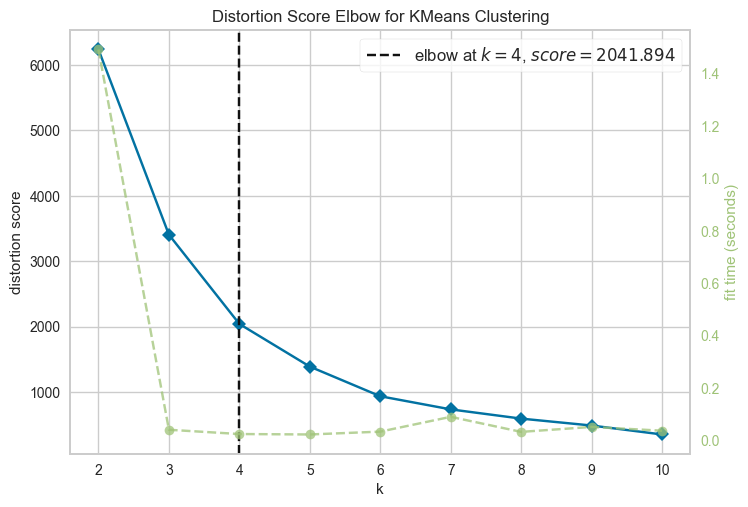

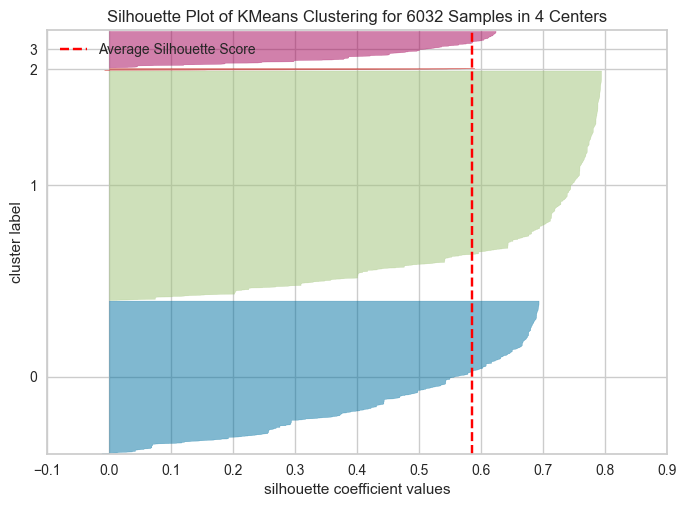

Tamaño del: cluster
1    3294
0    2190
3     522
2      26
Name: count, dtype: int64

Precio medio dentro del: cluster
0     20334.493957
1      7318.204532
2    145267.500000
3     43208.835617
Name: mean, dtype: float64

Precio medio por: cluster_manufacturer_model
0     19756.626915
1      8670.847098
2    145812.962963
3     42563.863971
Name: price, dtype: float64

Precio min por: cluster_manufacturer_model
0     1000
1     1000
2    95000
3     5400
Name: price, dtype: int64

Precio max por: cluster_manufacturer_model
0    270000
1    123456
2    275000
3    109000
Name: price, dtype: int64


In [68]:
# Obtener clusters por manufacturer y model
clustering_analyzer = ClusteringAnalyzer(vehicles, ["manufacturer", "model"])
vehicles = clustering_analyzer.analyze_and_cluster()

### VIN (Vehicle Identification Number)

In [69]:
# Verifica completitud de la variable
vehicles.vin.isna().mean()

0.41018947368421055

In [70]:
# Eliminar espacios en blanco dentro del atributo
vehicles["vin"] = vehicles["vin"].str.strip()

# Pasar a minúsculas los valores de vin
vehicles["vin"] = vehicles["vin"].str.lower()

# Reemplazar strings que no sean alpanuméricos por vacíos
vehicles["vin"] = vehicles["vin"].replace(r"[^a-zA-Z0-9]", "", regex=True)

In [71]:
# Estudiar la calidad del dato. Por definición, el VIN consta de 17 caracteres
# (números y letras)  que actúan como identificador único para el vehículo.
# Un VIN muestra las características únicas del automóvil, especificaciones y fabricante.
vin_len = vehicles.vin.map(lambda x: 0 if pd.isna(x) else len(x))

print(
    "Distribución de la longitud del dato en el atributo:", vin_len.value_counts(True)
)

Distribución de la longitud del dato en el atributo: vin
17    0.578316
0     0.410232
6     0.002442
13    0.001347
11    0.001137
10    0.001011
16    0.000968
14    0.000842
8     0.000758
12    0.000589
9     0.000547
5     0.000421
7     0.000337
4     0.000295
2     0.000211
15    0.000168
18    0.000126
3     0.000126
1     0.000126
Name: proportion, dtype: float64


In [72]:
# Convertir a NaN aquellos casos donde la longitud es diferente a 17
vehicles.loc[vin_len != 17, "vin"] = None

# Obtener la nueva distribución de la longitud del VIN
vin_len = vehicles.vin.map(lambda x: 0 if pd.isna(x) else len(x))

print(
    "Distribución de la longitud del dato en el atributo:", vin_len.value_counts(True)
)

Distribución de la longitud del dato en el atributo: vin
17    0.578316
0     0.421684
Name: proportion, dtype: float64


Considerando la información de la siguiente imagen se evalúa la posibilidad de incluir nuevos atributos. Por ejemplo, built_character (que corresponderá a dónde el vehículo fue construido) y security_code.

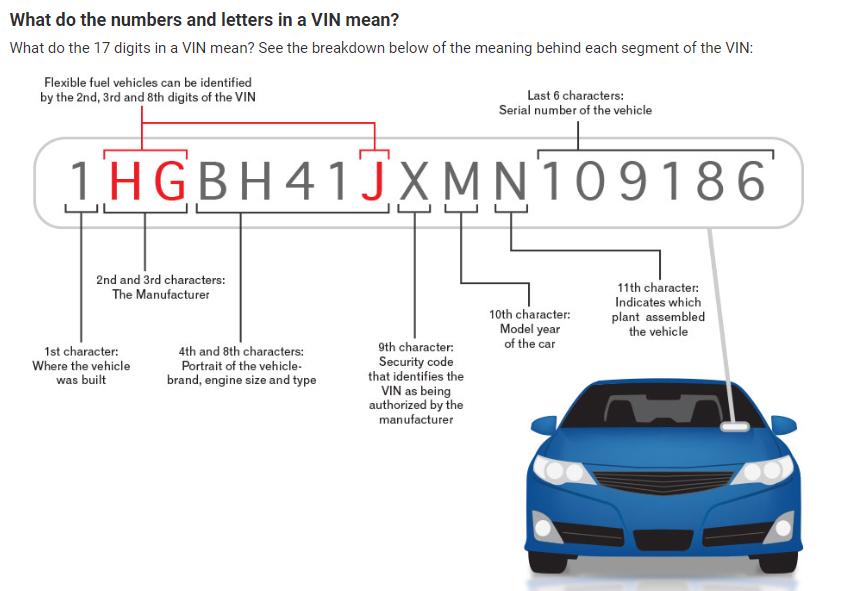

In [73]:
# Definición del atributo built_character
vehicles["built_character"] = vehicles.vin.str[0]

# Definición del atributo security_code
vehicles["security_code"] = vehicles.vin.str[10]

In [74]:
# Precio medio para los casos de VIN nulo
vehicles[vehicles.vin.isna()].price.mean()

11186.668996505243

In [75]:
# Definir como no_informado los casos nulos
vehicles["built_character"] = vehicles.built_character.fillna("no_informado")
vehicles["security_code"] = vehicles.security_code.fillna("no_informado")

In [76]:
# Precio medio por categoría de la variable security_code
vehicles.groupby("security_code")["price"].agg(["mean", "count"]).sort_values(
    "mean", ascending=False
)

,mean,count
security_code,,
x,24627.081545,233
e,22992.864896,866
g,22864.754130,1029
f,21980.203786,898
o,20700.000000,2
5,18359.882927,410
s,18102.541213,643
k,17721.981168,531
v,17673.371429,70


In [77]:
# Precio medio por categoría de la variable built_character
vehicles.groupby("built_character")["price"].agg(["mean", "count"]).sort_values(
    "mean", ascending=False
)

,mean,count
built_character,,
z,27719.924242,66
6,26328.333333,3
s,26307.814815,108
7,23244.250000,4
l,20165.437500,16
3,18797.780427,1594
w,18375.216922,1111
1,17545.813466,6015
g,17500.000000,1


##### Agrupación para built_character

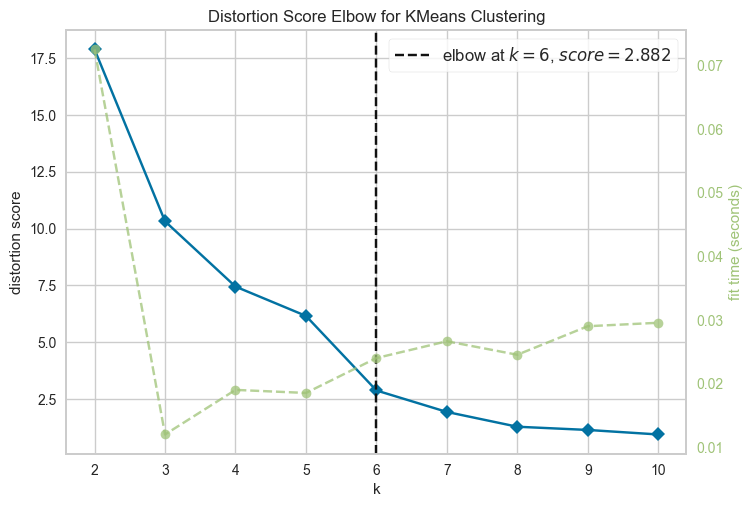

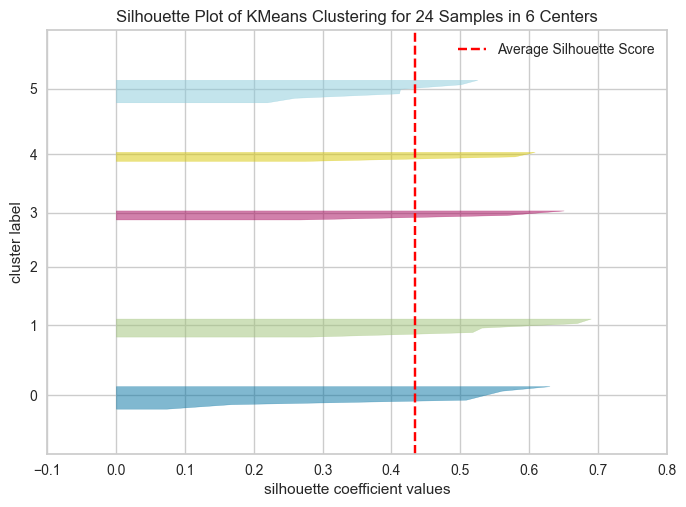

Tamaño del: cluster
0    6
5    6
1    5
4    3
3    3
2    1
Name: count, dtype: int64

Precio medio dentro del: cluster
0    18152.336379
1    13528.021428
2    26328.333333
3     7277.111111
4    25757.329686
5    11549.832151
Name: mean, dtype: float64

Precio medio por: cluster_built_character
0    17713.147570
1    12714.104658
2    26328.333333
3     8266.444444
4    26762.561798
5    11363.583312
Name: price, dtype: float64

Precio min por: cluster_built_character
0     1000
1     1000
2    14995
3     3595
4     1200
5     1000
Name: price, dtype: int64

Precio max por: cluster_built_character
0    185997
1    119900
2     31995
3     28988
4    266499
5    275000
Name: price, dtype: int64


In [78]:
# Obtener clusters por built_character
clustering_analyzer = ClusteringAnalyzer(vehicles, ["built_character"])
vehicles = clustering_analyzer.analyze_and_cluster()

##### Agrupación para security_code

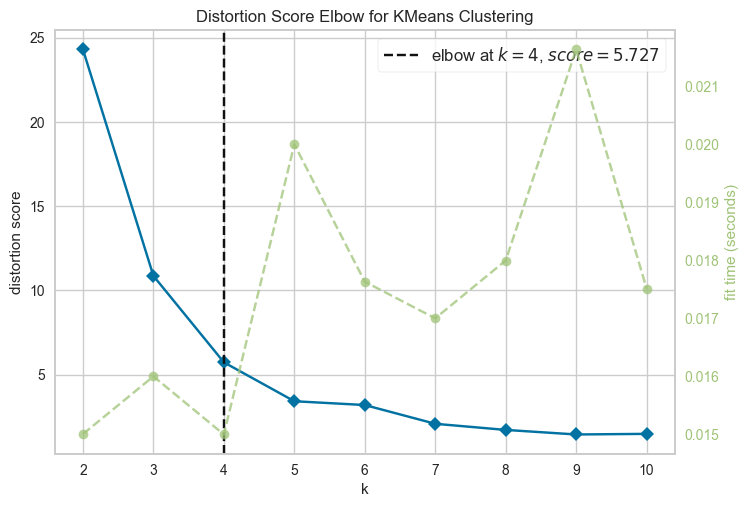

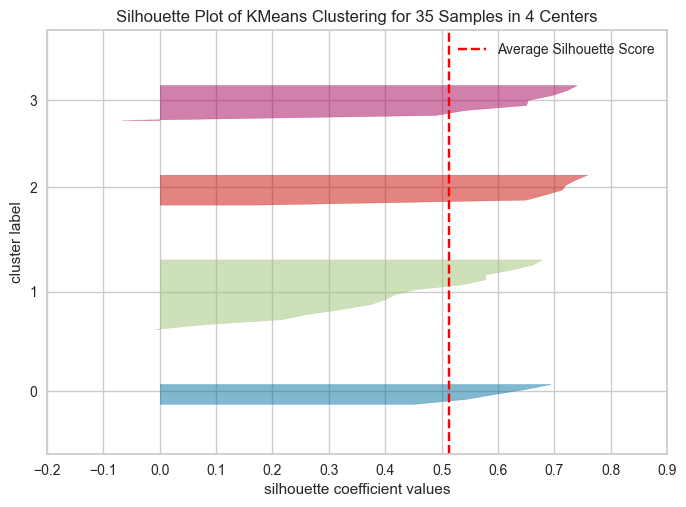

Tamaño del: cluster
1    15
3     8
2     7
0     5
Name: count, dtype: int64

Precio medio dentro del: cluster
0    22632.980872
1    14060.852452
2    10705.823045
3    17123.694688
Name: mean, dtype: float64

Precio medio por: cluster_security_code
0    22773.245046
1    14286.831340
2    11146.762007
3    17386.169832
Name: price, dtype: float64

Precio min por: cluster_security_code
0    1000
1    1000
2    1000
3    1132
Name: price, dtype: int64

Precio max por: cluster_security_code
0    185997
1    266499
2    275000
3    137200
Name: price, dtype: int64


In [79]:
# Obtener clusters por security_code
clustering_analyzer = ClusteringAnalyzer(vehicles, ["security_code"])
vehicles = clustering_analyzer.analyze_and_cluster()

### Atributos númericos

In [80]:
# Determinar qué atributos son numéricos
numeric_attributes = list(vehicles.select_dtypes(["float", "int"]).columns)
print("Los siguients atributos son númericos:", numeric_attributes)

Los siguients atributos son númericos: ['price', 'year', 'odometer', 'lat', 'long', 'number_of_crashes', 'poverty']


In [81]:
# Determinar la completez de los atributos
vehicles[numeric_attributes].isna().mean().sort_values()

price                0.000000
number_of_crashes    0.001263
poverty              0.001263
year                 0.002063
lat                  0.007832
long                 0.007832
odometer             0.174611
dtype: float64

In [82]:
# Antes de continuar con el análisis de las variables númericas
# se crea la variabla vehicle_age
vehicles["vehicle_age"] = datetime.now().year - vehicles["year"]

Para los atributos de tipo númerico podriamos pensar en emplear un algorítmo de python para la imputación dado que tienen muy poco valores faltantes. Esto con excepción del atributo **odometer**.

Antes de determinar cómo manejar el problema de valores faltantes para la variable **odometer** se estudia como se relacionan las variables númericas con el precio.

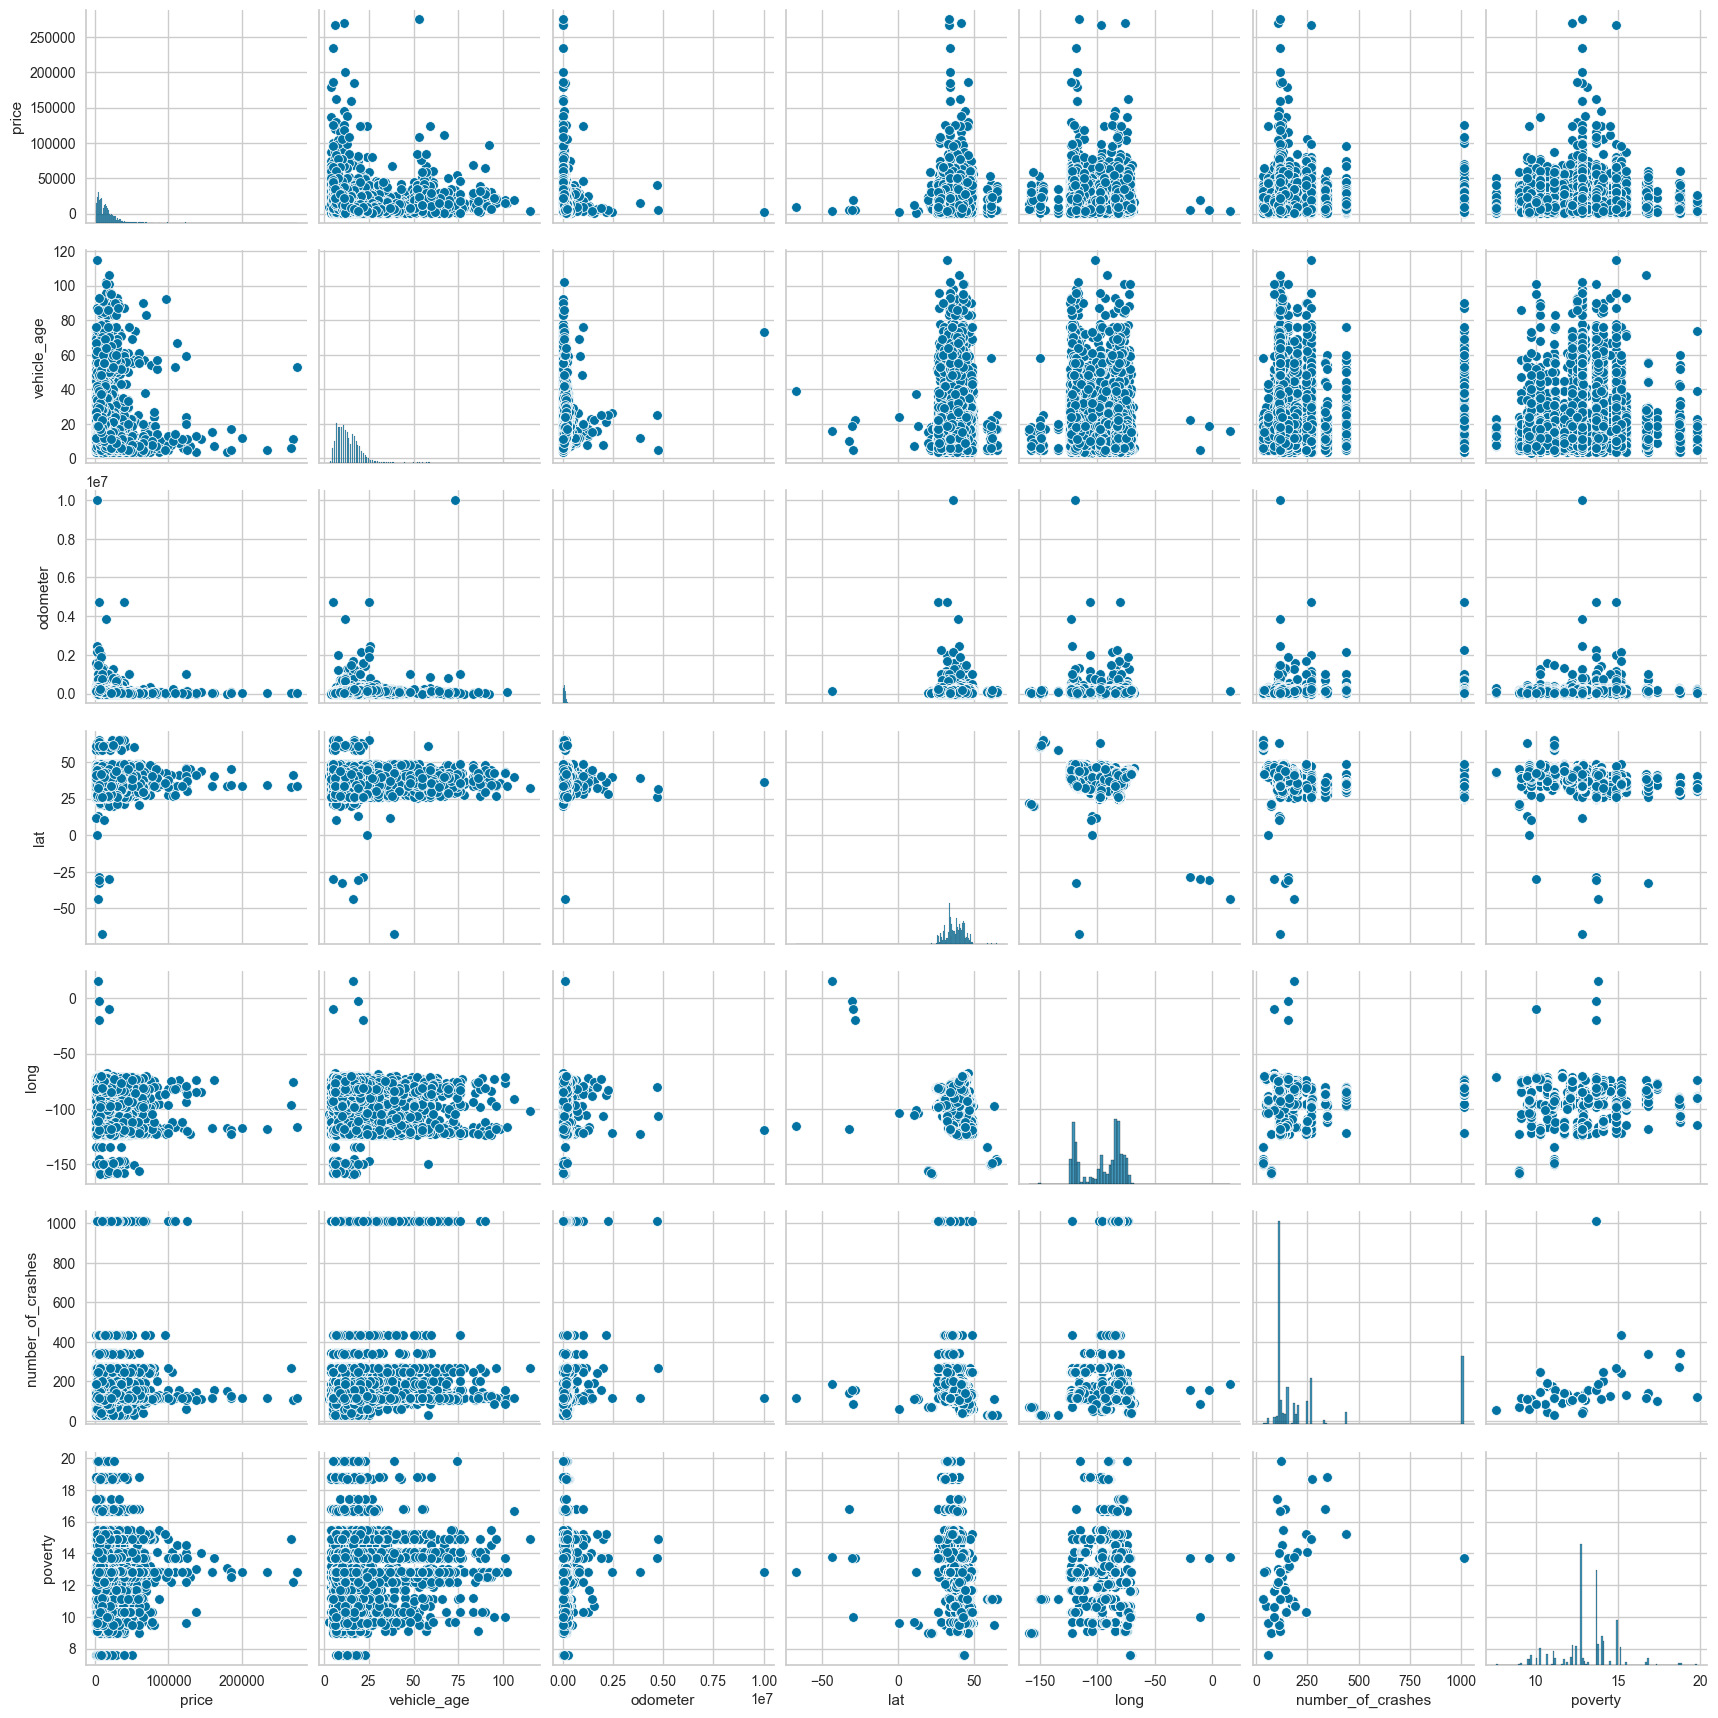

In [83]:
# Para realizar un primer acercamiento a este análisis se presenta la matriz de
# scatterplots. Sin embargo, cómo se puede notar no se observar relaciones claras
# en las nubes de puntos
sns.pairplot(
    vehicles[
        [
            "price",
            "vehicle_age",
            "odometer",
            "lat",
            "long",
            "number_of_crashes",
            "poverty",
        ]
    ]
)
plt.show()

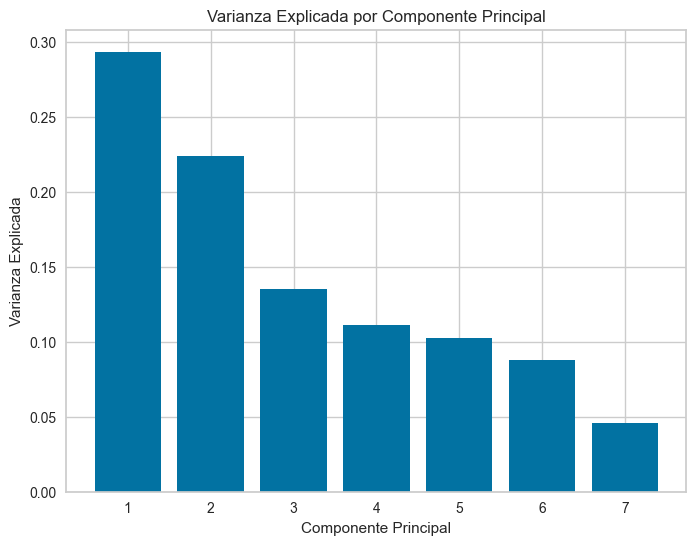

In [84]:
# Otra alternativa útil para estudiar como se asocian las variables númericas
# es un análisis de PCA. Se emplea esta herramienta como un forma de estimar
# cómo las variables se estan asociando.

# Estandarizar los datos

columns_pca = [
    "price",
    "vehicle_age",
    "odometer",
    "lat",
    "long",
    "number_of_crashes",
    "poverty",
]
scaler_pca = StandardScaler()
scaled_features_pca = scaler_pca.fit_transform(vehicles[columns_pca].dropna())

# Aplicar PCA
pca = PCA()
pca.fit(scaled_features_pca)

# Obtener las componentes principales
principal_components = pca.transform(scaled_features_pca)

# Crear DataFrame para visualizar las componentes principales
pca_df = pd.DataFrame(
    data=principal_components, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"]
)

# Visualizar las componentes principales
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel("Componente Principal")
plt.ylabel("Varianza Explicada")
plt.title("Varianza Explicada por Componente Principal")
plt.show()

In [85]:
print(
    "Varianza explicada del PCA:", np.round(sum(pca.explained_variance_ratio_[:2]), 2)
)

Varianza explicada del PCA: 0.52


Considerando que las dos primeras componentes explican el 52% de la variabilidad y el Variable Factor Map. Se puede concluir que el precio es independiente del número de choques y del nivel de pobreza del estado. Por otro lado, se observa que la antigüedad del vehículo está estrechamente relacionada a su kilometraje, por lo que incluir ambas variables en el modelo seria redundante, dado el número de valores faltantes en el atributo asociado al kilometraje se conservará la angitüedad del vehículo para el modelo.

Finalmente, se obsera como el precio es inversamente proporcional a la antigüedad del vehículo y a su kilometraje.

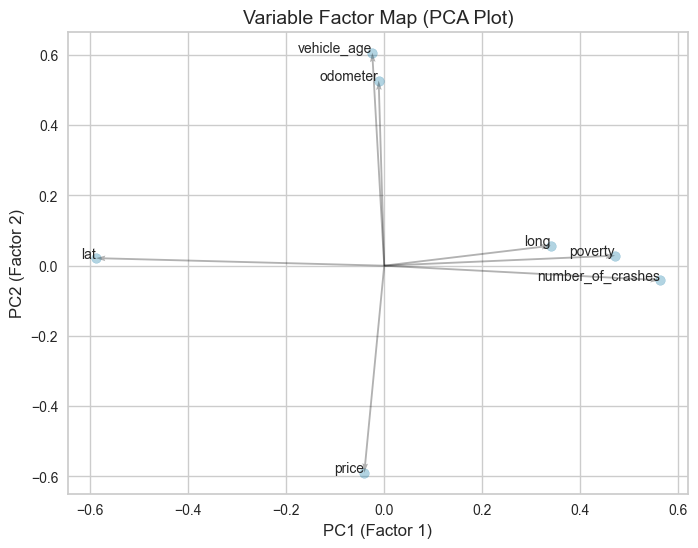

In [86]:
# Plot Variable Factor Map
plt.figure(figsize=(8, 6))
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.3)
plt.xlabel("PC1 (Factor 1)", fontsize=12)
plt.ylabel("PC2 (Factor 2)", fontsize=12)
plt.title("Variable Factor Map (PCA Plot)", fontsize=14)
plt.grid(True)

# Add variable names as annotations
for i, txt in enumerate(vehicles[columns_pca]):
    plt.annotate(
        txt,
        (pca.components_[0, i], pca.components_[1, i]),
        ha="right",
        va="baseline",
        fontsize=10,
    )

# Add vectors representing loadings at the center
plt.quiver(
    np.zeros(7),
    np.zeros(7),
    pca.components_[0],
    pca.components_[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="black",
    width=0.003,
    alpha=0.3,
)
plt.show()

Para concluir, se estudia el coeficiente de Spearman, ya que mediante los análisis anteriores solo se ha evaluado la correlación lineal de las variables.

In [87]:
# Determinar la correlación de Spearman entre el precio
# y el número de accidentes en el estado
spearman_crashes = stats.spearmanr(
    vehicles[vehicles.number_of_crashes.notna()].price,
    vehicles[vehicles.number_of_crashes.notna()].number_of_crashes,
)
print(
    "La correlación de Spearman entre el precio y el número de accidentes es:",
    spearman_crashes.statistic.round(2),
)

La correlación de Spearman entre el precio y el número de accidentes es: 0.02


In [88]:
# Determinar la correlación de Spearman entre el precio
# y el número de accidentes en el estado
spearman_crashes = stats.spearmanr(
    vehicles[vehicles.poverty.notna()].price,
    vehicles[vehicles.poverty.notna()].poverty,
)
print(
    "La correlación de Spearman entre el precio y el número de accidentes es:",
    spearman_crashes.statistic.round(2),
)

La correlación de Spearman entre el precio y el número de accidentes es: -0.04


Se concluye que no existe una correlación fuerte entre el precio y las variables de indole demográfico asociados al estado (número de accidentes y pobreza).

## Modelado

In [89]:
# Finalmente se seleccionan los atributos estudiados y trabajados en
# las secciones anteriores y se preparan los datos para el entrenamiento
selected_columns = [
    "price",
    "condition",
    "cylinders",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "drive_isna",
    "condition_isna",
    "paint_color_groups",
    "cluster_manufacturer_model",
    "cluster_built_character",
    "cluster_security_code",
    "vehicle_age",
]

# Inicializar la clase para preparar los datos para entrenamiento
preprocessor = DataPreprocessor(vehicles, selected_columns)

# Preparar los datos para entrenamiento
processed_dataset = preprocessor.get_processed_dataset()

In [90]:
# Definir las matrices para entrenamiento
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = (
    processed_dataset["X_train"],
    processed_dataset["X_val"],
    processed_dataset["X_test"],
    processed_dataset["y_train"],
    processed_dataset["y_val"],
    processed_dataset["y_test"],
)

### Modelo Regresión Lineal

In [91]:
# Modelo baseline de regresión lineal
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Obtener score en train
lr_score_train = lr.score(X_train_scaled, y_train)
lr_adjusted_score_train = r_cuadrado_ajustado(lr, X_train_scaled, y_train)
print("R^2 score en train:", lr_score_train.round(3))
print("R^2 ajustado en train:", lr_adjusted_score_train.round(3))

R^2 score en train: 0.571
R^2 ajustado en train: 0.569


In [92]:
# Obtener score en validación
lr_score_val = lr.score(X_val_scaled, y_val)
lr_adjusted_score_val = r_cuadrado_ajustado(lr, X_val_scaled, y_val)
print("R^2 score en val:", lr_score_val.round(3))
print("R^2 ajustado en val:", lr_adjusted_score_val.round(3))

R^2 score en val: 0.612
R^2 ajustado en val: 0.607


In [93]:
# Obtener score en test
lr_score_test = lr.score(X_test_scaled, y_test)
lr_adjusted_score_test = r_cuadrado_ajustado(lr, X_test_scaled, y_test)
print("R^2 score en test:", lr_score_test.round(3))
print("R^2 ajustado en test:", lr_adjusted_score_test.round(3))

R^2 score en test: 0.614
R^2 ajustado en test: 0.609


In [94]:
# Recordemos la distribución de nuestra variable
y_test.describe()

count      3562.000000
mean      14306.216732
std       12398.054058
min        1000.000000
25%        5995.000000
50%       11335.000000
75%       18995.000000
max      185997.000000
Name: price, dtype: float64

In [95]:
# Obtener las predicciones del modelo en el conjunto de train
y_pred_train = lr.predict(X_train_scaled)

# Calcular el error cuadrático medio
mse_train = mean_squared_error(y_train, y_pred_train)
print("Root Mean Squared Error on train set:", np.sqrt(mse_train))
print(
    "Número de desviaciones estándar que representa el rmse:",
    (np.sqrt(mse_train) / np.std(y_train)).round(2),
)

# Obtener los errores para train y su distribución
errors_train = y_train - y_pred_train
errors_train.describe()

Root Mean Squared Error on train set: 7866.830061240022
Número de desviaciones estándar que representa el rmse: 0.66


count    1.662500e+04
mean    -7.440077e-14
std      7.867067e+03
min     -4.113650e+04
25%     -4.222974e+03
50%     -9.906606e+02
75%      3.082633e+03
max      2.416567e+05
Name: price, dtype: float64

In [96]:
# Obtener las predicciones del modelo en el conjunto de validación
y_pred_val = lr.predict(X_val_scaled)

# Calcular el error cuadrático medio
mse_val = mean_squared_error(y_val, y_pred_val)
print("Root Mean Squared Error on validation set:", np.sqrt(mse_val))
print(
    "Número de desviaciones estándar que representa el rmse:",
    (np.sqrt(mse_val) / np.std(y_val)).round(2),
)


# Obtener los errores para val y su distribución
errors_val = y_val - y_pred_val
errors_val.describe()

Root Mean Squared Error on validation set: 7647.406391868642
Número de desviaciones estándar que representa el rmse: 0.62


count      3563.000000
mean       -104.656270
std        7647.763532
min      -27769.146856
25%       -4251.684628
50%       -1184.083515
75%        3114.521073
max      128050.607234
Name: price, dtype: float64

In [97]:
# Obtener las predicciones del modelo en el conjunto de test
y_pred_test = lr.predict(X_test_scaled)

# Calcular el error cuadrático medio
mse_test = mean_squared_error(y_test, y_pred_test)
print("Root Mean Squared Error on test set:", np.sqrt(mse_test))
print(
    "Número de desviaciones estándar que representa el rmse:",
    (np.sqrt(mse_test) / np.std(y_test)).round(2),
)


# Obtener los errores para test y su distribución
errors_test = y_test - y_pred_test
errors_test.describe()

Root Mean Squared Error on test set: 7698.869219120391
Número de desviaciones estándar que representa el rmse: 0.62


count     3562.000000
mean      -133.720954
std       7698.788597
min     -52157.348646
25%      -4445.070868
50%      -1104.048953
75%       2983.282366
max      63811.571105
Name: price, dtype: float64

##### Cálculo de las métricas de negocio

In [98]:
losses = np.minimum(y_pred_test - y_test, 0)
print("Pérdidas promedio del modelo:", losses.mean().round(2))

Pérdidas promedio del modelo: -2597.77


In [99]:
profits = np.maximum(y_pred_test - y_test, 0)
print("Ganancias promedio del modelo:", profits.mean().round(2))

Ganancias promedio del modelo: 2731.49


##### ¿Cuáles son las probabilidades de venta para cada vehículo?

In [100]:
# Cálcular la probabilidad de compra para cada conjunto de datos
prob_buying_test = probabilidad_de_compra(np.array(y_test), np.array(y_pred_test))
prob_buying_val = probabilidad_de_compra(np.array(y_val), np.array(y_pred_val))
prob_buying_train = probabilidad_de_compra(np.array(y_train), np.array(y_pred_train))

In [101]:
# Descriptivos Test
prob_buying_test.describe(percentiles=[0.05, 0.1, 0.20, 0.25, 0.3, 0.5, 0.75])

count    3562.000000
mean        0.688124
std         0.382169
min         0.000000
5%          0.000000
10%         0.000000
20%         0.220836
25%         0.421722
30%         0.557196
50%         0.891847
75%         1.000000
max         1.000000
dtype: float64

In [102]:
# Descriptivos Val
prob_buying_val.describe(percentiles=[0.05, 0.1, 0.20, 0.25, 0.3, 0.5, 0.75])

count    3563.000000
mean        0.689763
std         0.381668
min         0.000000
5%          0.000000
10%         0.000000
20%         0.214175
25%         0.409683
30%         0.559114
50%         0.894052
75%         1.000000
max         1.000000
dtype: float64

In [103]:
# Descriptivos Train
prob_buying_train.describe(percentiles=[0.05, 0.1, 0.20, 0.25, 0.3, 0.5, 0.75])

count    16625.000000
mean         0.695748
std          0.382034
min          0.000000
5%           0.000000
10%          0.000000
20%          0.231210
25%          0.422017
30%          0.571887
50%          0.909354
75%          1.000000
max          1.000000
dtype: float64

### Regresión Gamma

In [104]:
# Modelo baseline de regresión lineal
gr = GammaRegressor(alpha=0, max_iter=1000)
gr.fit(X_train_scaled, y_train)

# Obtener score en train
gr_score_train = gr.score(X_train_scaled, y_train)
print("R^2 score en train:", gr_score_train.round(3))

R^2 score en train: 0.5


In [105]:
# Obtener score en validación
gr_score_val = gr.score(X_val_scaled, y_val)
print("R^2 score en validación:", gr_score_val.round(3))

R^2 score en validación: 0.507


In [106]:
# Obtener score en test
gr_score_test = gr.score(X_test_scaled, y_test)
print("R^2 score en test:", gr_score_test.round(3))

R^2 score en test: 0.511


In [107]:
mse_train_gr = np.sqrt(mean_squared_error(y_train, gr.predict(X_train_scaled)))
mse_val_gr = np.sqrt(mean_squared_error(y_val, gr.predict(X_val_scaled)))
mse_test_gr = np.sqrt(mean_squared_error(y_test, gr.predict(X_test_scaled)))

print("Root Mean Sqrt Error for train:", mse_train_gr)
print("Root Mean Sqrt Error for test:", mse_test_gr)
print("Root Mean Sqrt Error for val:", mse_val_gr)

Root Mean Sqrt Error for train: 8200.38871366472
Root Mean Sqrt Error for test: 8485.965862144736
Root Mean Sqrt Error for val: 7971.706396355633


In [108]:
losses_gr = np.minimum(gr.predict(X_test_scaled) - y_test, 0)
print("Pérdidas promedio del modelo:", losses_gr.mean().round(2))

Pérdidas promedio del modelo: -2626.12


In [109]:
profits_gr = np.maximum(gr.predict(X_test_scaled) - y_test, 0)
print("Ganancias promedio del modelo:", profits_gr.mean().round(2))

Ganancias promedio del modelo: 2860.6


In [110]:
# Cálcular la probabilidad de compra para cada conjunto de datos
prob_buying_test_gr = probabilidad_de_compra(
    np.array(y_test), gr.predict(X_test_scaled)
)
prob_buying_test_gr.describe(percentiles=[0.05, 0.1, 0.20, 0.25, 0.3, 0.5, 0.75])

count    3562.000000
mean        0.678852
std         0.385953
min         0.000000
5%          0.000000
10%         0.000000
20%         0.196141
25%         0.393591
30%         0.527743
50%         0.884679
75%         1.000000
max         1.000000
dtype: float64